In [53]:
from __future__ import annotations

import numpy as np

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from nltk.stem.snowball import SnowballStemmer


from ordpy import ordinal_distribution, complexity_entropy

import matplotlib.pyplot as plt

from tqdm import tqdm

import nolds
import spacy

import logging

## Semantic Trajectories

In [54]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Device:', device)

nlp = spacy.load("ru_core_news_sm")
stemmer = SnowballStemmer("russian")
    
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-base-cased-russian-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-base-cased-russian-sentiment").to(device)

Device: mps


In [55]:
BAD_SYMBOLS = ['\xa0', '\n', ',', '.', ';', ':', '!', '?', '(', ')', '—', '…']  

def prepare_text(text_path, seq_len=False):
    with open(text_path, 'r') as f:
        text = f.read().lower().strip()
  
    for bas_symbol in BAD_SYMBOLS:
        text = text.replace(bas_symbol, ' ')
    text = [token.strip().lower() for token in text.split()]
    
    return text[:seq_len] if seq_len else text
    
    
def prepaer_lemmas(text_path, seq_len=False):
    """
    text_path: Путь до файла с текстов в формате txt
    """
    
    with open(text_path, 'r') as f:
        text = f.read().lower().strip()
  
    for bas_symbol in BAD_SYMBOLS:
        text = text.replace(bas_symbol, ' ')
    doc = nlp(text)
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_space]

    return lemmas[:seq_len] if seq_len else lemmas

def prepare_stems(text_path, seq_len=False):
    """
    text_path: Путь до файла с текстов в формате txt
    """
    with open(text_path, 'r') as f:
        text = f.read().lower().strip()
  
    for bas_symbol in BAD_SYMBOLS:
        text = text.replace(bas_symbol, ' ')

    stemms = [stemmer.stem(word) for word in text.split()]

    return stemms[:seq_len] if seq_len else stemms

In [56]:
def prepare_text(
    text_path, 
    preproc_type='None',
    seq_len=False):
    with open(text_path, 'r') as f:
        text = f.read().lower().strip()
  
    for bas_symbol in BAD_SYMBOLS:
        text = text.replace(bas_symbol, ' ')
   
    if preproc_type == 'lemmas':
        doc = nlp(text)
        preprocessed_text = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_space]
    elif preproc_type == 'stems':
        preprocessed_text = [stemmer.stem(word) for word in text.split()]
    elif preproc_type == 'default':
        preprocessed_text = [token.strip().lower() for token in text.split()]
    else:
        logging.error(f'Unknown preprocessing type: {preproc_type}')
        return None
    
    return preprocessed_text[:seq_len] if seq_len else preprocessed_text

In [57]:
seq_len = 100

text = prepare_text("Детство.txt", preproc_type='default', seq_len=seq_len)
lemmas = prepare_text("Детство.txt", preproc_type='lemmas', seq_len=seq_len)
stems = prepare_text("Детство.txt", preproc_type='stems', seq_len=seq_len)

Sentiment trajectory

In [58]:
def prepare_sentiment_trajectory(
    preprocessed_text,
    model,
    tokenizer
) -> list[float]:
    """
    {0: 'neutral', 1: 'positive', 2: 'negative'}
    """
    tokenized_words = []
    for word in tqdm(preprocessed_text):
        inputs = tokenizer(word, return_tensors="pt")
        tokenized_words.append(inputs)
        
    sentiment_traectory = []
    for inputs in tqdm(tokenized_words):
        inputs = inputs.to(device)
        outputs = model(**inputs)
        lprobs = torch.nn.functional.softmax(outputs.logits, dim=1)[0].tolist()
        sentiment_traectory.append(lprobs[1] if lprobs[1] > lprobs[2] else -lprobs[2])
    return sentiment_traectory

In [59]:
words_sentiment_trajectory = prepare_sentiment_trajectory(text, model, tokenizer)

100%|██████████| 100/100 [00:01<00:00, 73.13it/s]


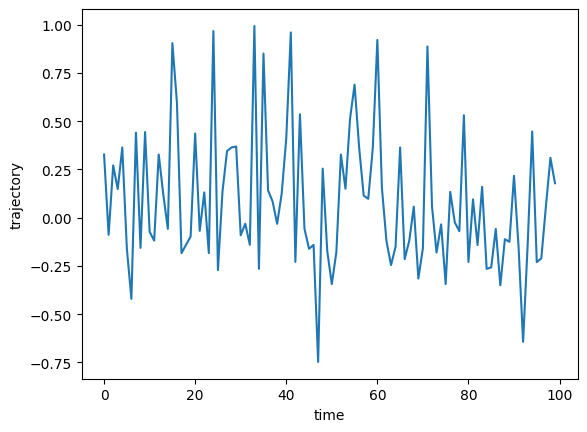

In [60]:
plt.plot(words_sentiment_trajectory)
plt.xlabel('time')
plt.ylabel('trajectory')
plt.show()

In [61]:
lyap_kwargs = {"emb_dim": 6, "lag": 2, "min_tsep": 20}
lyap_exp = nolds.lyap_r(words_sentiment_trajectory, **lyap_kwargs)
lyap_exp

0.04090482410485849

In [62]:
lemmas_sentiment_trajectory = prepare_sentiment_trajectory(lemmas, model, tokenizer)

100%|██████████| 100/100 [00:01<00:00, 58.23it/s]


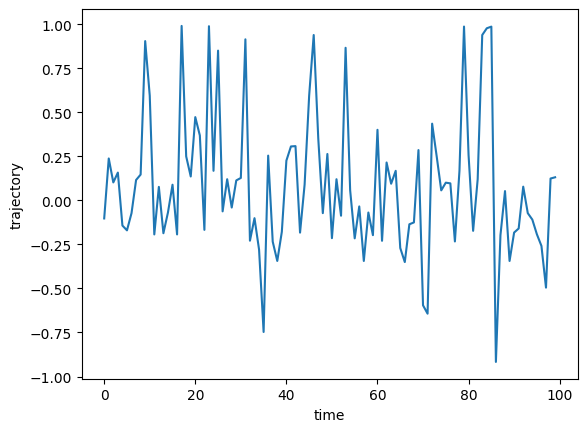

In [63]:
plt.plot(lemmas_sentiment_trajectory)
plt.xlabel('time')
plt.ylabel('trajectory')
plt.show()

In [64]:
lyap_kwargs = {"emb_dim": 6, "lag": 2, "min_tsep": 20}
lyap_exp = nolds.lyap_r(lemmas_sentiment_trajectory, **lyap_kwargs)
lyap_exp

0.009068089426352581

In [65]:
stems_sentiment_trajectory = prepare_sentiment_trajectory(stems, model, tokenizer)

100%|██████████| 100/100 [00:01<00:00, 89.59it/s]


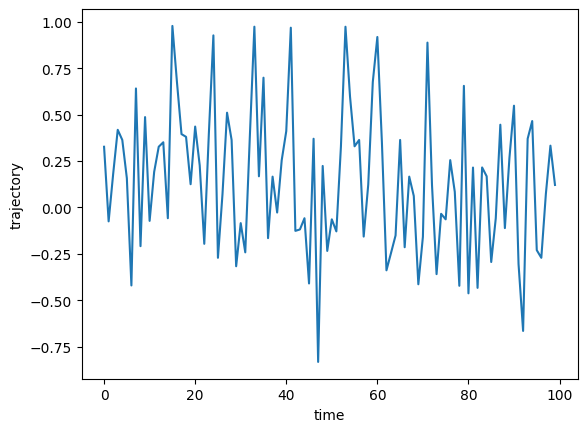

In [66]:
plt.plot(stems_sentiment_trajectory)
plt.xlabel('time')
plt.ylabel('trajectory')
plt.show()

In [67]:
lyap_kwargs = {"emb_dim": 6, "lag": 2, "min_tsep": 20}
lyap_exp = nolds.lyap_r(stems_sentiment_trajectory, **lyap_kwargs)
lyap_exp

-0.01239304149694702

In [68]:
#word_sentiment_trajectory
ce_word_sentiment_trajectory = complexity_entropy(words_sentiment_trajectory, dx=3, probs=False)

#lemma_sentiment_trajectory
ce_lemma_sentiment_trajectory = complexity_entropy(lemmas_sentiment_trajectory, dx=3, probs=False)

#stem_sentiment_trajectory
ce_stems_sentiment_trajectory = complexity_entropy(stems_sentiment_trajectory, dx=3, probs=False)

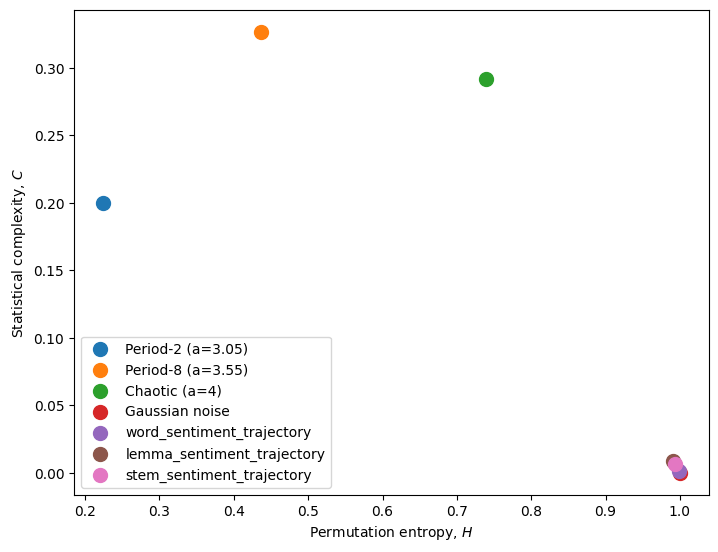

In [69]:
import numpy as np
import ordpy
from matplotlib import pylab as plt

def logistic(a=4, n=100000, x0=0.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(n - 1):
        x[i + 1] = a * x[i] * (1 - x[i])
    return(x)

f, ax = plt.subplots(figsize=(8.19, 6.3))

#examples
time_series = [logistic(a) for a in [3.05, 3.55, 4]]
time_series += [np.random.normal(size=100000)]
HC = [ordpy.complexity_entropy(series, dx=4) for series in time_series]
for HC_, label_ in zip(HC, ['Period-2 (a=3.05)',
                            'Period-8 (a=3.55)',
                            'Chaotic (a=4)',
                            'Gaussian noise']):
    ax.scatter(*HC_, label=label_, s=100)

ax.scatter(*ce_word_sentiment_trajectory, label='word_sentiment_trajectory', s=100)
ax.scatter(*ce_lemma_sentiment_trajectory, label='lemma_sentiment_trajectory', s=100)
ax.scatter(*ce_stems_sentiment_trajectory, label='stem_sentiment_trajectory', s=100)

ax.set_xlabel('Permutation entropy, $H$')
ax.set_ylabel('Statistical complexity, $C$')

ax.legend();

## Sentiment trajectories

In [70]:
tfidf_matrix = TfidfVectorizer().fit_transform(text)

In [71]:
svd_dim = 4
u, s, vT = svds(tfidf_matrix, k=svd_dim)

In [72]:
d2 = 1
semantic_trajectory = [u_i[0:d2] for u_i in u]

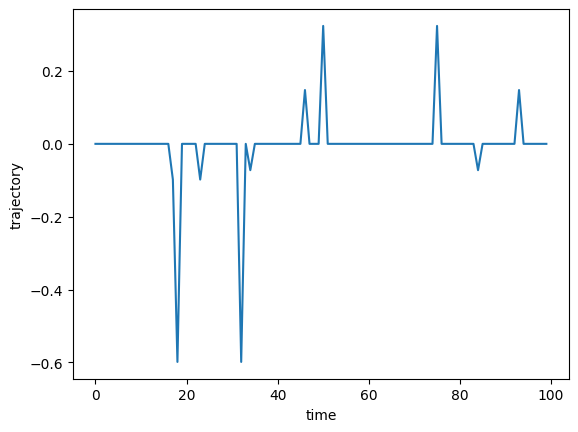

In [73]:
plt.plot(semantic_trajectory)
plt.xlabel('time')
plt.ylabel('trajectory')
plt.show()

In [74]:
lyap_kwargs = {"emb_dim": 6, "lag": 2, "min_tsep": 20}
lyap_exp = nolds.lyap_r(semantic_trajectory, **lyap_kwargs)
lyap_exp

-inf